# PUI Final Take-home Exam from SUNG HOON YANG (shy256)
## MOTIVATION:
There is a known connection between school performance and the environment that a child is exposed to, including environmental conditions that may affect health, exposure to violence which affects stress level, and socioeconomic features, including income, which may determine the ability of a student to get help. Nonetheless, the modeling of school performance is difficult, as measures of performance may be biased and environmental features hard to measure.

In spite of that, I would like you to try and model performance, measures through the SAT score, of NYC students as a function of exposure to crime, measured through reports of crimes in school, living conditions, measured through the incidence of respiratory and drug related issues in the area, and optionally income.

The analysis is at the PUMA level. All data are accessible through NYC open data, the NY state open data portal (NY.gov), or my CARTO account. Remember the general rules and recommendations

There are 11 tasks, each worth 10 points: 6 data gathering and wrangling tasks, and 5 analysis tasks. This sums up to 110, but the max points is 100, so you have 11/10 opportunities to get full score.

There are hints: follow the links in each tasks, and shortcuts and partial solutions (which will cost you some of the points). Remember that you can skip forward using a solution and go back to a task later. As long as you can produce the data that you used for the following tasks you will get the points for those tasks.

REMEMBER THAT PERFORMING THE TASKS IS NOT SUFFICIENT! YOU HAVE TO COMMENT ON YOUR RESULTS TO DEMONSTRATE SCIENTIFIC UNDERSTANDING AND NOT ONLY TECHNICAL PROFICIENCY! You can leave your comments and conclusions in the figure captions, and in markdown cells.

In [496]:
# this is me
__author__ = "Sung Hoon Yang, CUSP NYU 2018"

# limit the number of same warnings to once
import warnings
# To ignore some warnings
import warnings
warnings.filterwarnings(action='once')
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=UserWarning)

# Built-ins
import os
import sys
import math

# Basic
import numpy as np
import pandas as pd
import matplotlib
import geopandas as gpd
from shapely.geometry import Point
from shapely.geometry import MultiPolygon
from shapely.geometry import Polygon
# font = {'family':'normal','weight':'bold','size':88};matplotlib.rc('font', **font);
import matplotlib.pyplot as plt
import seaborn as sns
from pylab import imshow
np.random.seed(999)

# Processing 
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn import utils

# Stat
from scipy import stats
import statsmodels as sm
import statsmodels.formula.api as smf
import statsmodels.api as sma
from statsmodels.regression.linear_model import WLS
from statsmodels.tools.tools import add_constant
from scipy.stats import pearsonr 

# Regularization using Ridge, Lasso
from sklearn import linear_model

# PCA module
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from mpl_toolkits.mplot3d import Axes3D
from sklearn import preprocessing

# Time Series AutoRegression
from pandas.plotting import lag_plot
from pandas.plotting import autocorrelation_plot
from sklearn.metrics import mean_squared_error
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.ar_model import AR

# Clustering
from scipy.spatial.distance import cdist, pdist # used by k-means elbow method
from sklearn.cluster import KMeans
# sys.path.insert(0, '/nfshome/shy256/fall18/appliedDataScience/hw5')
# from elbow import elbow # Copied from Session 9 Notebook, and stored in above path under name elbow.py
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.mixture import GaussianMixture
from sklearn.cluster import DBSCAN

# Classification
from sklearn.linear_model import LogisticRegression
from sklearn import svm
from sklearn.metrics import confusion_matrix

# Random Forest
from sklearn.ensemble  import RandomForestClassifier as rfc
from sklearn.metrics import classification_report
from sklearn.ensemble import RandomForestRegressor
from sklearn.datasets import make_regression

# Misc. Utilities
import re
from datetime import datetime
from copy import deepcopy
from itertools import product
from pprint import pprint

   
pd.set_option('display.max_colwidth', -1)
pd.set_option('display.max_columns', None)  

%matplotlib inline

In [222]:
"""
CartoDB Querying Purposes
"""

import pandas as pd

try:
    import urllib2 as ulib
except ImportError:
    import urllib as ulib

try:
    from StringIO import BytesIO as io
except ImportError:
    from io import BytesIO as io

try:
    from urllib import urlencode as urlencode
except ImportError:
    from urllib.parse import urlencode as urlencode
    
try:
    from urllib import urlopen as urlopen
except ImportError:
    from urllib.request import urlopen as urlopen
    
try:
    from urllib2 import HTTPError as HTTPError
except ImportError:
    from urllib.error import HTTPError as HTTPError

In [505]:
def featureImportancePlot(rf, labels):
    '''plots feature importance for random forest
    rf: the random forest model fit to the data
    labels: the names of the features
    '''
    
    importances = rf.feature_importances_
    indices = np.argsort(importances)[::-1]
    std = np.std([tree.feature_importances_ for tree in rf.estimators_],
             axis=0)


    pl.figure()
    pl.title("Feature importances")
    pl.bar(range(indices.shape[0]), rf.feature_importances_[indices],
       color="SteelBlue", yerr=std[indices], align="center")
    pl.xticks(range(indices.shape[0]), np.array(labels)[indices], rotation=90)
    pl.xlim([-1, indices.shape[0]])
    pl.show()

### PART I Data gathering and wrangling
#### 1. Collect the school related data (10 points)
The dataset can be found on NYC open data. The dataset you should use is the 2012 SAT Results (depending on access method it could be caller 2012_SAT_Results)

#### 1.1 Collect School SAT data (5 points)
 - read in the SAT scores for NYC schools (3 points)
 - create a new feature: the average of all 3 SAT scores

In [2]:
_sat_res_url = 'https://data.cityofnewyork.us/api/views/f9bf-2cp4/rows.csv?accessType=DOWNLOAD'
__RAW_SAT_RES__ = pd.read_csv(_sat_res_url)
__RAW_SAT_RES__.head()

,DBN,SCHOOL NAME,Num of SAT Test Takers,SAT Critical Reading Avg. Score,SAT Math Avg. Score,SAT Writing Avg. Score
0,01M292,HENRY STREET SCHOOL FOR INTERNATIONAL STUDIES,29,355,404,363
1,01M448,UNIVERSITY NEIGHBORHOOD HIGH SCHOOL,91,383,423,366
2,01M450,EAST SIDE COMMUNITY SCHOOL,70,377,402,370
3,01M458,FORSYTH SATELLITE ACADEMY,7,414,401,359
4,01M509,MARTA VALLE HIGH SCHOOL,44,390,433,384


In [3]:
__RAW_SAT_RES__.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 478 entries, 0 to 477
Data columns (total 6 columns):
DBN                                478 non-null object
SCHOOL NAME                        478 non-null object
Num of SAT Test Takers             478 non-null object
SAT Critical Reading Avg. Score    478 non-null object
SAT Math Avg. Score                478 non-null object
SAT Writing Avg. Score             478 non-null object
dtypes: object(6)
memory usage: 22.5+ KB


#### Please note that below process takes care of: 
2.2 Fill in the missing data as appropriate keeping in mind that the school with no crimes are not included i the crime-in-school database, so there you can assume that there were 0 crimes, **but the missing SAT scores cannot be assumed to be 0 of course.**

They are dropped


In [4]:
invalid_dta_ix = (
    __RAW_SAT_RES__[
        ['SAT Critical Reading Avg. Score', 'SAT Math Avg. Score', 'SAT Writing Avg. Score']
    ] == 's'
).apply(any, axis=1)

In [73]:
# calc avg for valid data
_sat_avg = __RAW_SAT_RES__[~invalid_dta_ix][
    [
        'SAT Critical Reading Avg. Score'
        , 'SAT Math Avg. Score'
        , 'SAT Writing Avg. Score'
    ]
].astype(float).mean(axis=1)


In [74]:
sat = __RAW_SAT_RES__[~invalid_dta_ix].copy()
sat['SATall'] = _sat_avg
sat.rename(
    mapper = {
        'SAT Math Avg. Score': 'SATmath'
    }
    , inplace=True
    , axis=1
)
sat = sat[['DBN', 'SATmath', 'SATall']]


_save_path = os.path.join(os.environ["PUIDATA"], "satScoresNYC.csv")
if not os.path.exists(_save_path):
    print('Creating %s' % _save_path)
    sat.to_csv(_save_path, index=False)
sat.head()

,DBN,SATmath,SATall
0,01M292,404,374.000000
1,01M448,423,390.666667
2,01M450,402,383.000000
3,01M458,401,391.333333
4,01M509,433,402.333333


### 1.2 Collect School Crime data (5 points)
This data collects crimes in schools from 2010 to 2016 on NYC open data.

The file is called School Safety Report

Number of crimes are reported by school and by crime category. This file contains location information (Lat/Lon for each school in the dataset) which will be the basis of your geospatial aggregations

read in the NYPD crimes in school report
inspect the distribution of crimes per school
plot the distribution of "Average number of Major" crimes by school
You need to decide which variable should be used to identify the school. Since you will later merge this with the SAT scores it makes sense to use a variable that is in both datasets.

In [8]:
_ssr_url = 'https://data.cityofnewyork.us/api/views/qybk-bjjc/rows.csv?accessType=DOWNLOAD'

__RAW_SSR_RES__ = pd.read_csv(_ssr_url)
__RAW_SSR_RES__.head()

,School Year,Building Code,DBN,Location Name,Location Code,Address,Borough,Geographical District Code,Register,Building Name,...,Borough Name,Postcode,Latitude,Longitude,Community Board,Council District,Census Tract,BIN,BBL,NTA
0,2013-14,K001,15K001,P.S. 001 The Bergen,K001,309 47 STREET,K,15.0,"1,277",NaN,...,BROOKLYN,11220.0,40.649042,-74.012289,7.0,38.0,80.0,3011821.0,3.007550e+09,Sunset Park West ...
1,2013-14,K002,17K002,Parkside Preparatory Academy,K002,655 PARKSIDE AVENUE,K,17.0,479,655 PARKSIDE AVENUE CONSOLIDATED LOCATION,...,BROOKLYN,11226.0,40.656183,-73.951583,9.0,40.0,802.0,3378201.0,3.050500e+09,Prospect Lefferts Gardens-Wingate ...
2,2013-14,K002,75K141,P.S. K141,K141,655 PARKSIDE AVENUE,K,17.0,397,655 PARKSIDE AVENUE CONSOLIDATED LOCATION,...,BROOKLYN,11226.0,40.656183,-73.951583,9.0,40.0,802.0,3378201.0,3.050500e+09,Prospect Lefferts Gardens-Wingate ...
3,2013-14,K002,84K704,Explore Charter School,K704,655 PARKSIDE AVENUE,K,17.0,NaN,655 PARKSIDE AVENUE CONSOLIDATED LOCATION,...,BROOKLYN,11226.0,40.656183,-73.951583,9.0,40.0,802.0,3378201.0,3.050500e+09,Prospect Lefferts Gardens-Wingate ...
4,2013-14,K002,NaN,655 PARKSIDE AVENUE CONSOLIDATED LOCATION,NaN,655 PARKSIDE AVENUE,K,17.0,876,655 PARKSIDE AVENUE CONSOLIDATED LOCATION,...,BROOKLYN,11226.0,40.656183,-73.951583,9.0,40.0,802.0,3378201.0,3.050500e+09,Prospect Lefferts Gardens-Wingate ...


#### Please note that below process takes care of: 
Fill in the missing data as appropriate keeping in mind that the **school with no crimes are not included i the crime-in-school database, so there you can assume that there were 0 crimes**, but the missing SAT scores cannot be assumed to be 0 of course. hints (4 points)


In [71]:
dist_maj_crimes = __RAW_SSR_RES__.fillna(0).groupby('DBN').agg(
    {
        'Major N': 'mean'
    }   
)
dist_maj_crimes.min(), dist_maj_crimes.max(), dist_maj_crimes.mean(), dist_maj_crimes.std()

(Major N    0.0
 dtype: float64, Major N    7.333333
 dtype: float64, Major N    0.133391
 dtype: float64, Major N    0.40937
 dtype: float64)

(0, 1600)

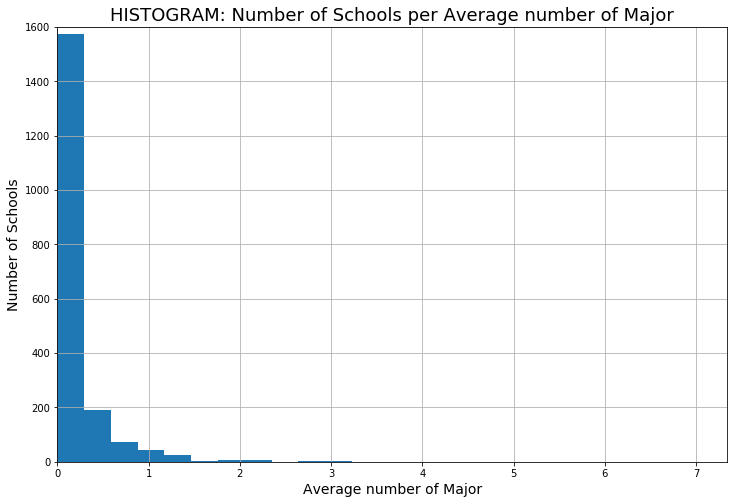

In [72]:
dist_maj_crimes.hist(
    figsize=(12, 8)
    , bins=25
)
ax = plt.gca()
ax.set_title('HISTOGRAM: Number of Schools per Average number of Major', fontsize=18)
ax.set_xlabel('Average number of Major', fontsize=14)
ax.set_xlim(left=0, right=7.34)
ax.set_ylabel('Number of Schools', fontsize=14)
ax.set_ylim(bottom=0, top=1600)

#### Explanation & Observation
Above is the histogram of Number of schools per bin that is defined as Average Number of Major Crimes in School Averaged out for years from 2010 to 2016
Unsurprisingly, the vast majority of schools belong to the first bin, meaning that there is zero to very few major crimes in schools. The greatest outlier has 7.33 major crimes per year.

### 2. Merge school crime and SAT data (10 points)¶
Identify a common column and merge based on that. mind that there may be duplicates! especially if you only save the relevant columns

#### 2.1 Merge the SAT and the crime in school data based on the school identifier. (4 points)
#### 2.2 Fill in the missing data as appropriate keeping in mind that the school with no crimes are not included i the crime-in-school database, so there you can assume that there were 0 crimes, but the missing SAT scores cannot be assumed to be 0 of course. hints (4 points)
#### 2.3 Count the individual school location: there may be multiple schools in a single building. What could be the implication of this in your analysis? hints (2 points)
Notes : remember to monitor and comment on the number of datapoints that are lost in the merge

SOLUTION you can get the solution https://serv.cusp.nyu.edu/~fbianco/finaldata2018/schoolsDF.csv (loosing 10 points)

#### 2.1 Merge the SAT and the crime in school data based on the school identifier. (4 points)

In [166]:
schools = sat.merge(
    __RAW_SSR_RES__
    , on=['DBN']
).fillna(0.0)[
    [
        'DBN'
        , 'School Year'
        , 'Major N'
        , 'Oth N'
        , 'NoCrim N'
        , 'Prop N'
        , 'Vio N'
        , 'AvgOfMajor N'
        , 'AvgOfOth N'
        , 'AvgOfNoCrim N'
        , 'AvgOfProp N'
        , 'AvgOfVio N'
        , 'Latitude'
        , 'Longitude'
        , 'SATall'
        , 'SATmath'
    ]
]
schools.iloc[:, 2:] = schools.iloc[:, 2:].astype(float)
schools.head()

,DBN,School Year,Major N,Oth N,NoCrim N,Prop N,Vio N,AvgOfMajor N,AvgOfOth N,AvgOfNoCrim N,AvgOfProp N,AvgOfVio N,Latitude,Longitude,SATall,SATmath
0,01M292,2013-14,0.0,0.0,0.0,0.0,0.0,0.00,0.00,0.00,0.00,0.00,40.713684,-73.986336,374.000000,404.0
1,01M292,2014-15,0.0,0.0,0.0,0.0,0.0,0.00,0.00,0.00,0.00,0.00,40.713684,-73.986336,374.000000,404.0
2,01M292,2015-16,0.0,0.0,0.0,0.0,0.0,0.00,0.00,0.00,0.00,0.00,40.713684,-73.986336,374.000000,404.0
3,01M448,2013-14,1.0,0.0,2.0,1.0,0.0,0.35,1.06,1.09,0.73,0.50,40.712399,-73.984497,390.666667,423.0
4,01M448,2014-15,0.0,1.0,2.0,1.0,0.0,0.27,1.11,1.38,0.80,0.48,40.712399,-73.984497,390.666667,423.0


#### 2.2 Fill in the missing data as appropriate keeping in mind that the school with no crimes are not included i the crime-in-school database, so there you can assume that there were 0 crimes, but the missing SAT scores cannot be assumed to be 0 of course. hints (4 points)
was dealt with in Q1

#### 2.3 Count the individual school location: there may be multiple schools in a single building. What could be the implication of this in your analysis? hints (2 points)

In [167]:
schools.groupby(['Longitude', 'Latitude']).count()['DBN'].shape

(259,)

#### there are 259 unique locations

below I am going to make the final dataset that introduces two aggregation layers **DBN** and **School Year**

In [ ]:
schools = schools.groupby(['Longitude', 'Latitude', 'DBN', 'School Year']).agg(
    {
        'Major N': 'max'
        , 'Oth N': 'max'
        , 'NoCrim N': 'max'
        , 'Prop N': 'max'
        , 'Vio N': 'max'
        , 'AvgOfMajor N': 'max'
        , 'AvgOfOth N': 'max'
        , 'AvgOfNoCrim N': 'max'
        , 'AvgOfProp N': 'max'
        , 'AvgOfVio N': 'max'
        , 'SATall': 'max'
        , 'SATmath': 'max'
    }
).reset_index()\
    [[c for c in schools.columns if c != 'School Year']]\
    .drop_duplicates()

_save_path = os.path.join(os.environ["PUIDATA"], "schoolsDF.csv")
if not os.path.exists(_save_path):
    print('Creating %s' % _save_path)
    schools.to_csv(_save_path, index=False)

In [359]:
schools.head()

,DBN,Major N,Oth N,NoCrim N,Prop N,Vio N,AvgOfMajor N,AvgOfOth N,AvgOfNoCrim N,AvgOfProp N,AvgOfVio N,Latitude,Longitude,SATall,SATmath
0,31R455,0.0,0.0,0.0,0.0,0.0,0.00,0.00,0.00,0.00,0.00,40.528092,-74.192032,472.666667,486.0
3,31R607,0.0,0.0,0.0,0.0,0.0,0.00,0.00,0.00,0.00,0.00,40.528092,-74.192032,383.333333,375.0
6,31R047,0.0,0.0,0.0,0.0,0.0,0.00,0.00,0.00,0.00,0.00,40.581315,-74.158589,451.000000,451.0
9,31R064,0.0,0.0,0.0,0.0,0.0,0.00,0.00,0.00,0.00,0.00,40.581315,-74.158589,398.333333,412.0
12,31R445,0.0,19.0,34.0,9.0,8.0,0.81,5.43,8.48,3.24,2.33,40.634573,-74.141818,426.333333,438.0


In [358]:
schools.shape

(653, 15)

### 3. Visualize the school related data (10 points)
#### 3.1 plot the Math SAT score and the average of all SAT scores (the feature you created in Task 1) as a function of two crime statistics (5 points)
make sure your data is numeric, plot SAT Math score and the average SAT score (Math, reading, writing), each one against the

number of major crimes and
the average number of crimes

In [99]:
vis_dta = schools[[
    'DBN'
    , 'AvgOfNoCrim N'
    , 'AvgOfMajor N'
    , 'SATall'
    , 'SATmath'
]].copy()

Text(0.5, 0.98, 'Scatter-Matrix: SAT scores vs. Avg No. Crimes & No. of Major Crimes')

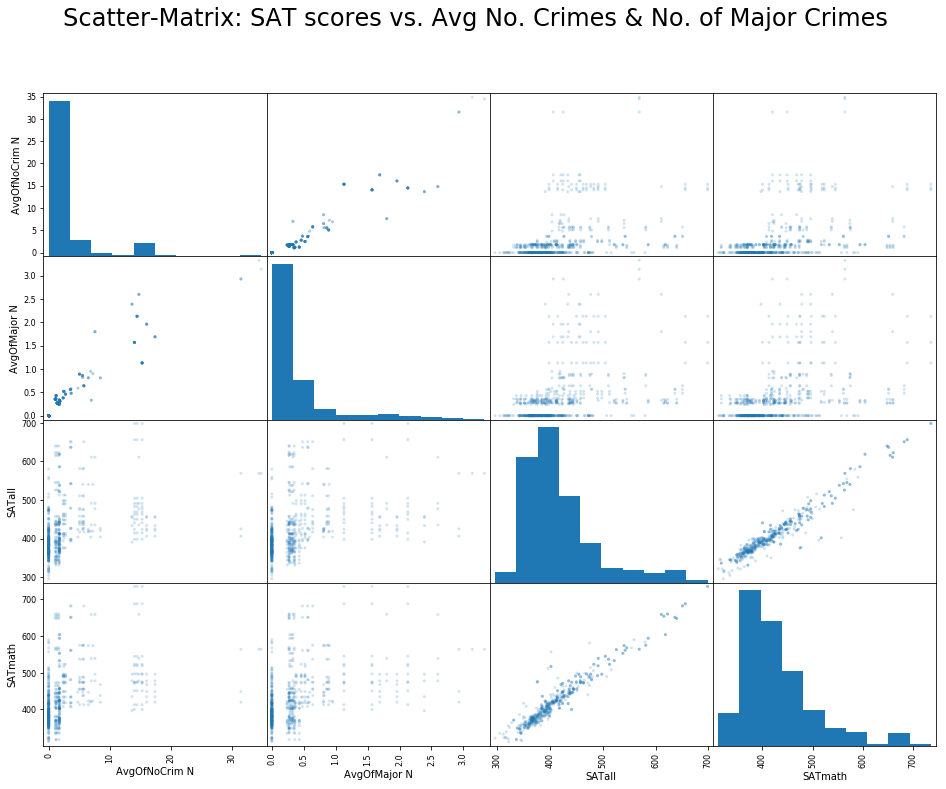

In [100]:
pd.plotting.scatter_matrix(
    vis_dta
    , figsize=(16, 12) 
    , alpha=0.2
)
plt.suptitle('Scatter-Matrix: SAT scores vs. Avg No. Crimes & No. of Major Crimes', fontsize=24)


#### IN ORDER TO FIND SAT SCORES VS. CRIME METRICS, PLEASE REFER TO:
* upper right 2 x 2 plots OR
* lower left 2 x 2 plots

All four plots show that the values concentrate around in AvgOfNoCrim N OR AvgOfMajor N nearly equals to 0.0. The rest of data does not seem to show explicitly monotonic relationship



#### 3.2 create geometry from the lat-lon coordinates and map the location of each school in the dataset (5 points)
hints, also reviewed in the final review

In [103]:
_ssr_latlon = __RAW_SSR_RES__.groupby('DBN').agg(
    {
        'Longitude': 'max'
        , 'Latitude': 'max'
    }
)

In [106]:
_ssr_latlon['geometry'] = pd.Series(
    [Point(xy) for xy in zip(_ssr_latlon['Longitude'], _ssr_latlon['Latitude'])]
    , index=_ssr_latlon.index
)
_ssr_latlon.head()

,Longitude,Latitude,geometry
DBN,,,
01M015,-73.979022,40.721807,POINT (-73.979022 40.721807)
01M019,-73.983818,40.729636,POINT (-73.983818 40.729636)
01M020,-73.986648,40.721540,POINT (-73.986648 40.72154)
01M034,-73.975181,40.726473,POINT (-73.97518100000001 40.726473)
01M063,-73.986381,40.724117,POINT (-73.98638100000001 40.724117)


Text(128.0679018524453, 0.5, 'Latitude in EPSG 4326')

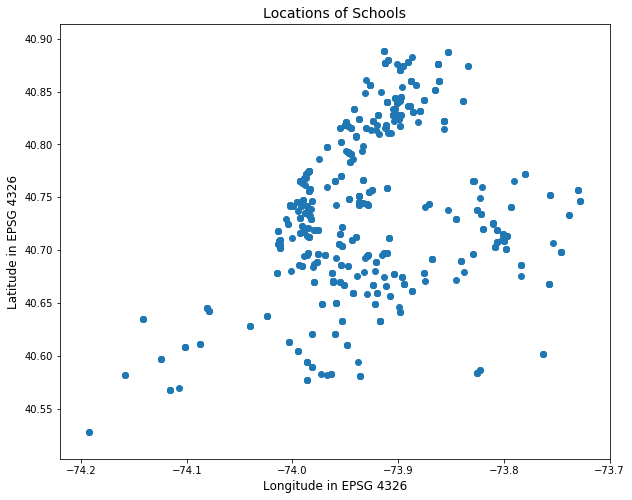

In [135]:
_sc = schools.merge(
    _ssr_latlon
    , left_on='DBN'
    , right_index=True
)

crs = {'init': 'epsg:4326'}
school_gdf = gpd.GeoDataFrame(_sc, crs=crs)
school_gdf.plot(
    figsize=(12, 8)
)
ax = plt.gca()
plt.title('Locations of Schools', fontsize=14)
plt.xlabel('Longitude in EPSG 4326', fontsize=12)
plt.ylabel('Latitude in EPSG 4326', fontsize=12)

### 4 Gather Asthma and drugs hospital discharge (10 points)
Use the SPARCS dataset which contains de-identified hospitalization data for the state of NY in 2012. This file is available at https://healthdata.ny.gov/. This is a large file and it will be time consuming to read it online or download it. Reduce the data to only the 5 NYC boroughs hint

Note: As you do all this, keep track of how many facilities are lost at each step

SHORTCUT you can download the preprocessed SPARCS data without the coordinates (https://serv.cusp.nyu.edu/~fbianco/finaldata2018/discharge.csv loosing 6 points, and you will need to perform task 4.3 by yourself) and with the coordinates (https://serv.cusp.nyu.edu/~fbianco/finaldata2018/asmaDrugsData.csv (loosing 10 points and you will still have to turn the lon-lat pairs into actual coordinate POINT objects hint)

#### 4.1 read in the SPARCS data (3 points)
read in the SPARCS data
throw away the data that is not in NYC
#### 4.2 calculate the fraction of asthma and drug related diagnoses per facility (3 points)
count the number of asthma and drug related diagnoses per facility
Find in the file all asthma-related diagnosis : I used those that include asthma and respiratory issues as diagnosis that are relevant, and I used alcohol and drug related issues as well as poisoning from psychotropic substances as relevant drug-related diagnoses hint

calculate the fraction of asthma/drug diagnoses over all diagnoses per facility

#### 4.1 read in the SPARCS data (3 points)

In [137]:
__SPARCS_URL__ = 'https://health.data.ny.gov/api/views/u4ud-w55t/rows.csv?accessType=DOWNLOAD'

In [154]:
!cd "$PUIDATA"; \
 rm -rf final_pui_sparc_shp; \
 mkdir final_pui_sparc_shp; \
 cd final_pui_sparc_shp; \
 wget -q "$__SPARCS_URL__" -O sparc.csv; \
 ls

sparc.csv


In [155]:
__RAW_SPARC__ = pd.read_csv(
    os.path.join(PUIDATA, 'final_pui_sparc_shp', 'sparc.csv')
)
__RAW_SPARC__.head()

/usr/local/Cellar/python/3.6.5_1/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3020: DtypeWarning: Columns (10) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,Health Service Area,Hospital County,Operating Certificate Number,Facility ID,Facility Name,Age Group,Zip Code - 3 digits,Gender,Race,Ethnicity,...,Payment Typology 2,Payment Typology 3,Attending Provider License Number,Operating Provider License Number,Other Provider License Number,Birth Weight,Abortion Edit Indicator,Emergency Department Indicator,Total Charges,Total Costs
0,Western NY,Allegany,226700.0,37.0,Cuba Memorial Hospital Inc,30 to 49,147,F,White,Not Span/Hispanic,...,NaN,NaN,90301264.0,NaN,NaN,0,N,Y,5511.95,5582.49
1,Western NY,Allegany,226700.0,37.0,Cuba Memorial Hospital Inc,70 or Older,147,F,White,Not Span/Hispanic,...,NaN,NaN,90301264.0,NaN,NaN,0,N,Y,4783.20,5162.82
2,Western NY,Allegany,226700.0,37.0,Cuba Memorial Hospital Inc,30 to 49,147,F,White,Not Span/Hispanic,...,NaN,NaN,90301264.0,NaN,NaN,0,N,Y,3829.15,4056.52
3,Western NY,Allegany,226700.0,37.0,Cuba Memorial Hospital Inc,0 to 17,147,F,White,Not Span/Hispanic,...,NaN,NaN,182357.0,NaN,NaN,0,N,Y,1108.20,1644.75
4,Western NY,Allegany,226700.0,37.0,Cuba Memorial Hospital Inc,70 or Older,147,F,White,Not Span/Hispanic,...,NaN,NaN,90301264.0,NaN,NaN,0,N,Y,3418.18,3370.87


In [161]:
__RAW_SPARC__ = __RAW_SPARC__[
    np.isin(
        __RAW_SPARC__['Hospital County'] # element for testing
        , ['Manhattan', 'Queens', 'Bronx', 'Kings', 'Richmond'] # test_elements
    )
]
__RAW_SPARC__.head()

,Health Service Area,Hospital County,Operating Certificate Number,Facility ID,Facility Name,Age Group,Zip Code - 3 digits,Gender,Race,Ethnicity,...,Payment Typology 2,Payment Typology 3,Attending Provider License Number,Operating Provider License Number,Other Provider License Number,Birth Weight,Abortion Edit Indicator,Emergency Department Indicator,Total Charges,Total Costs
954417,New York City,Bronx,7000002.0,1165.0,Jacobi Medical Center,0 to 17,104,F,Black/African American,Not Span/Hispanic,...,Medicaid,NaN,197201.0,NaN,NaN,0,N,Y,10408.87,8618.38
954464,New York City,Bronx,7000002.0,1165.0,Jacobi Medical Center,50 to 69,104,M,Black/African American,Not Span/Hispanic,...,NaN,NaN,186946.0,NaN,NaN,0,N,Y,4652.69,3852.35
954762,New York City,Bronx,7000002.0,1165.0,Jacobi Medical Center,30 to 49,104,F,Other Race,Spanish/Hispanic,...,Medicaid,NaN,3872.0,NaN,NaN,0,N,Y,4044.20,3348.53
954951,New York City,Bronx,7000002.0,1165.0,Jacobi Medical Center,0 to 17,104,M,Other Race,Spanish/Hispanic,...,Medicaid,NaN,261112.0,NaN,NaN,0,N,Y,9130.51,7559.92
954967,New York City,Bronx,7000002.0,1165.0,Jacobi Medical Center,50 to 69,104,F,White,Not Span/Hispanic,...,NaN,NaN,253123.0,NaN,NaN,0,N,Y,4171.46,3453.90


#### 4.2 calculate the fraction of asthma and drug related diagnoses per facility (3 points)

#### Hint: Selecting discharge diagnoses

This is somewhat arbitrary and if you fill like you can make a better choice go ahead. I chose the following discharge diagnoses:

**'Asthma', 'Respiratory failure; insufficiency; arrest (adult)', 'Respiratory distress syndrome'** 
for asthma related issue, and <br>
**'Poisoning by psychotropic agents', 'Alcohol-related disorders', 'Substance-related disorders'** for drug relates issues.


The selection works the same as the selection of NYC facilities, setting  the diagnosis to be equal to one of the relevant diagnoses.

These kind of data manipulations, slicing addays by indices with boolean conditions, were reviewed in class many times and are in most of my notebooks


In [213]:
nd = __RAW_SPARC__.index.size
print("number of NYC discharges", nd)

number of NYC discharges 1199520


In [214]:
nycF = __RAW_SPARC__['Facility ID'].unique().size
print("number of NYC facilities in the dataset", nycF)

number of NYC facilities in the dataset 61


In [215]:
def _set_asthma_disease_flag(val):
    """
    test_dis: elements that are to be marked with a flag
    return pd.Series whose elements are 1 if flag 0 if not eligible for flagging
    """
    if val in ['Asthma', 'Respiratory failure; insufficiency; arrest (adult)', 'Respiratory distress syndrome']:
        return 1
    return 0

def _set_drug_disease_flag(val):
    """
    test_dis: elements that are to be marked with a flag
    return pd.Series whose elements are 1 if flag 0 if not eligible for flagging
    """
    if val in ['Poisoning by psychotropic agents', 'Alcohol-related disorders', 'Substance-related disorders']:
        return 1
    return 0

__RAW_SPARC__['asthma_flag'] = __RAW_SPARC__['CCS Diagnosis Description'].apply(_set_asthma_disease_flag)
__RAW_SPARC__['drug_flag'] = __RAW_SPARC__['CCS Diagnosis Description'].apply(_set_drug_disease_flag)
__RAW_SPARC__.head()

,Health Service Area,Hospital County,Operating Certificate Number,Facility ID,Facility Name,Age Group,Zip Code - 3 digits,Gender,Race,Ethnicity,Length of Stay,Type of Admission,Patient Disposition,Discharge Year,CCS Diagnosis Code,CCS Diagnosis Description,CCS Procedure Code,CCS Procedure Description,APR DRG Code,APR DRG Description,APR MDC Code,APR MDC Description,APR Severity of Illness Code,APR Severity of Illness Description,APR Risk of Mortality,APR Medical Surgical Description,Payment Typology 1,Payment Typology 2,Payment Typology 3,Attending Provider License Number,Operating Provider License Number,Other Provider License Number,Birth Weight,Abortion Edit Indicator,Emergency Department Indicator,Total Charges,Total Costs,asthma_flag,drug_flag
954417,New York City,Bronx,7000002.0,1165.0,Jacobi Medical Center,0 to 17,104,F,Black/African American,Not Span/Hispanic,3,Emergency,Home or Self Care,2012,128,Asthma,0,NO PROC,141,Asthma,4,Diseases and Disorders of the Respiratory System,1,Minor,Minor,Medical,Medicaid,Medicaid,NaN,197201.0,NaN,NaN,0,N,Y,10408.87,8618.38,1,0
954464,New York City,Bronx,7000002.0,1165.0,Jacobi Medical Center,50 to 69,104,M,Black/African American,Not Span/Hispanic,1,Emergency,Home or Self Care,2012,128,Asthma,0,NO PROC,141,Asthma,4,Diseases and Disorders of the Respiratory System,1,Minor,Minor,Medical,Medicaid,NaN,NaN,186946.0,NaN,NaN,0,N,Y,4652.69,3852.35,1,0
954762,New York City,Bronx,7000002.0,1165.0,Jacobi Medical Center,30 to 49,104,F,Other Race,Spanish/Hispanic,1,Emergency,Home or Self Care,2012,128,Asthma,0,NO PROC,141,Asthma,4,Diseases and Disorders of the Respiratory System,2,Moderate,Minor,Medical,Medicaid,Medicaid,NaN,3872.0,NaN,NaN,0,N,Y,4044.20,3348.53,1,0
954951,New York City,Bronx,7000002.0,1165.0,Jacobi Medical Center,0 to 17,104,M,Other Race,Spanish/Hispanic,3,Emergency,Home or Self Care,2012,128,Asthma,0,NO PROC,141,Asthma,4,Diseases and Disorders of the Respiratory System,2,Moderate,Minor,Medical,Medicaid,Medicaid,NaN,261112.0,NaN,NaN,0,N,Y,9130.51,7559.92,1,0
954967,New York City,Bronx,7000002.0,1165.0,Jacobi Medical Center,50 to 69,104,F,White,Not Span/Hispanic,1,Emergency,Home or Self Care,2012,102,Nonspecific chest pain,0,NO PROC,203,Chest pain,5,Diseases and Disorders of the Circulatory System,1,Minor,Minor,Medical,Self-Pay,NaN,NaN,253123.0,NaN,NaN,0,N,Y,4171.46,3453.90,0,0


In [216]:
nyca = __RAW_SPARC__[__RAW_SPARC__['asthma_flag'] == 1]['asthma_flag'].count()
print("number of asthma related cases in NYC", nyca) 

number of asthma related cases in NYC 30717


In [217]:
nycd = __RAW_SPARC__[__RAW_SPARC__['drug_flag'] == 1]['drug_flag'].count()
print("number of drug related cases in NYC", nycd)

number of drug related cases in NYC 46336


In [218]:
discharge = __RAW_SPARC__.groupby('Facility ID').agg(
    {
        'Health Service Area': 'count'
        , 'asthma_flag': 'sum'
        , 'drug_flag': 'sum'
    }
)
discharge.head()

,Health Service Area,asthma_flag,drug_flag
Facility ID,,,
1164.0,4917,0,2389
1165.0,20956,1123,1279
1168.0,15889,580,1006
1169.0,43650,2105,323
1172.0,23142,1826,611


In [219]:
discharge['asthmaRatio'] = discharge['asthma_flag'] * 1.0 / discharge['Health Service Area']
discharge['drugsRatio'] = discharge['drug_flag'] * 1.0 / discharge['Health Service Area']
discharge.reset_index()[
    [
        'Facility ID'
        , 'asthmaRatio'
        , 'drugsRatio'
    ]
].head()

,Facility ID,asthmaRatio,drugsRatio
0,1164.0,0.000000,0.485865
1,1165.0,0.053588,0.061033
2,1168.0,0.036503,0.063314
3,1169.0,0.048225,0.007400
4,1172.0,0.078904,0.026402


In [220]:
_save_path = os.path.join(os.environ["PUIDATA"], "discharge.csv")
if not os.path.exists(_save_path):
    print('Creating %s' % _save_path)
    discharge.to_csv(_save_path, index=False)

discharge.head()

Creating /Users/sunghoonyang/PycharmProjects/ds_workspace/data/fall18_pui_final/discharge.csv


,Health Service Area,asthma_flag,drug_flag,asthmaRatio,drugsRatio
Facility ID,,,,,
1164.0,4917,0,2389,0.000000,0.485865
1165.0,20956,1123,1279,0.053588,0.061033
1168.0,15889,580,1006,0.036503,0.063314
1169.0,43650,2105,323,0.048225,0.007400
1172.0,23142,1826,611,0.078904,0.026402


In [221]:
discharge.shape

(61, 5)

#### 4.3 find the location of each facility (4 points)
The facility coordinate information is on my Carto account and can be accessed with a SQL query (hint)

count and comment on the number of facilities left after the merge

The SQL source is "https://fb55.carto.com:443/api/v2/sql?q=" and the DB name is "nyc_facilities".

You can use the script queryCarto.py

In [231]:
def queryCartoDB(query, source, formatting = 'CSV'):
    '''queries carto datasets from a given carto account
    Arguments: 
    query - string: a valid sql query string
    format - outlut format  OPTIONAL (default CSV)
    source - a valid sql api endpoint OPTIONAL (default carto fb55 account)
    Returns:
    the return of the sql query AS A STRING
    NOTES:
    designed for the carto API, tested only with CSV return format'''
    
    
    data = urlencode({'format': formatting, 'q': query}).encode("utf-8")
    try:
        response = urlopen(source, data)
        return response.read()
    except HTTPError as e:
        raise (ValueError('\n'.join(ast.literal_eval(e.readline())['error'])))
        
def get_data(query, sql_source):
    '''submits a query to queryCartoDB and returns a pandas dataframe
    Arguments: 
    query - string: a valid sql query string
    source - a valid sql api endpoint OPTIONAL (e.g. fb55 account)
    '''
    try:
        return pd.read_csv(io(queryCartoDB(query, source=sql_source)), sep = ',')
    except ValueError as v:
        print (str(v))

query = """
SELECT
    facility_id
    , facility_location
FROM fb55.nyc_facilities
"""
nyc_facilities = get_data(query, 'https://fb55.carto.com:443/api/v2/sql?q=')
nyc_facilities.head()

,facility_id,facility_location
0,1320,"(40.654518, -73.945045)"
1,6448,"(40.653175, -73.886772)"
2,6754,"(40.689243, -73.956383)"
3,1206,"(40.846165, -73.904655)"
4,1207,"(40.814503, -73.919029)"


In [258]:
t = (-70, 40)
tuple(reversed(t))

(40, -70)

Text(126.26411179294212, 0.5, 'Latitude in EPSG 4326')

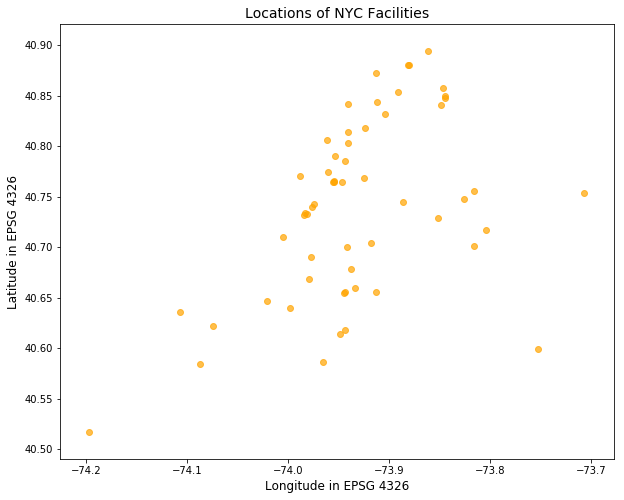

In [261]:
nyc_facilities['geometry'] = [Point(tuple(reversed(eval(xy)))) for xy in nyc_facilities['facility_location']]
disch_fclti = discharge.merge(
    nyc_facilities
    , left_index=True
    , right_on='facility_id'
)
crs = {'init': 'epsg:4326'}
disch_fclti_gdf = gpd.GeoDataFrame(disch_fclti, crs=crs)
disch_fclti_gdf.plot(
    figsize=(12, 8)
    , color='orange'
    , alpha=0.7
)
ax = plt.gca()
plt.title('Locations of NYC Facilities', fontsize=14)
plt.xlabel('Longitude in EPSG 4326', fontsize=12)
plt.ylabel('Latitude in EPSG 4326', fontsize=12)

### 5. Aggregate at the PUMA level (10 points)
#### 5.1 getting PUMA geodata (4 points)
You have done it many times! including in HW9 and in one of the midterms. The modeling will happen at the PUMA level, so get the PUMA data and assign to each puma a measure of sat performance, of crime, and of health

plot the PUMAs, the medical facilities, and the schools in each of the 3 datasets

In [240]:
__PUMA_SHP_URL__ = 'https://data.cityofnewyork.us/api/geospatial/cwiz-gcty?method=export&format=Shapefile'

In [244]:
!cd "$PUIDATA"; ls

discharge.csv       final_pui_sparc_shp satScoresNYC.csv    schoolsDF.csv


In [246]:
!cd "$PUIDATA"; \
 rm -rf final_pui_puma_shp; \
 mkdir final_pui_puma_shp; \
 cd final_pui_puma_shp; \
 wget "$__PUMA_SHP_URL__" -O puma.zip; \
 unzip puma.zip; \
 ls

--2018-12-15 16:53:59--  https://data.cityofnewyork.us/api/geospatial/cwiz-gcty?method=export&format=Shapefile
Resolving data.cityofnewyork.us (data.cityofnewyork.us)... 52.206.140.199, 52.206.140.205, 52.206.68.26
Connecting to data.cityofnewyork.us (data.cityofnewyork.us)|52.206.140.199|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [application/zip]
Saving to: ‘puma.zip’

puma.zip                [ <=>                ] 966.17K  --.-KB/s    in 0.1s    

2018-12-15 16:54:00 (6.78 MB/s) - ‘puma.zip’ saved [989354]

Archive:  puma.zip
  inflating: geo_export_b00ab5ef-2875-4fee-8e80-5f358849620d.dbf  
  inflating: geo_export_b00ab5ef-2875-4fee-8e80-5f358849620d.shp  
  inflating: geo_export_b00ab5ef-2875-4fee-8e80-5f358849620d.shx  
  inflating: geo_export_b00ab5ef-2875-4fee-8e80-5f358849620d.prj  
geo_export_b00ab5ef-2875-4fee-8e80-5f358849620d.dbf
geo_export_b00ab5ef-2875-4fee-8e80-5f358849620d.prj
geo_export_b00ab5ef-2875-4fee-8e80-5f358849620d.sh

In [ ]:
__PUMA_SHP__ = gpd.read_file(
    os.path.join(PUIDATA, 'final_pui_puma_shp', 'geo_export_b00ab5ef-2875-4fee-8e80-5f358849620d.shp')
)

Text(125.22632875612317, 0.5, 'Latitude in EPSG 4326')

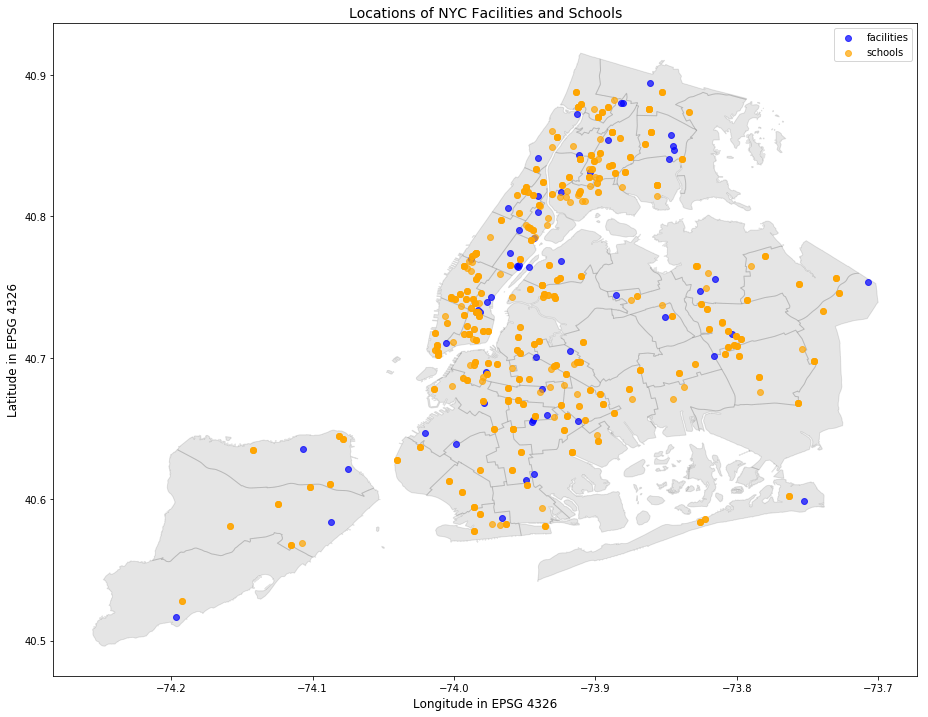

In [333]:
__PUMA_SHP__.plot(
    figsize=(16, 12)
    , color = 'k'
    , edgecolor = 'k'
    , alpha=0.1
    ,
)
ax = plt.gca()


# facilities
disch_fclti_gdf.plot(
    color='blue'
    , alpha=0.7
    , ax=ax
    , label='facilities'
    , 
)
# schools
school_gdf.plot(
    color='orange'
    , alpha=0.7    
    , label='schools'    
    , ax=ax
)
ax.legend()
plt.title('Locations of NYC Facilities and Schools', fontsize=14)
plt.xlabel('Longitude in EPSG 4326', fontsize=12)
plt.ylabel('Latitude in EPSG 4326', fontsize=12)

### 5.2 join hospital facilities and PUMA data (3 points)
join the PUMA data with the medical facilities and school data. The resulting dataframe should have :

* a puma number (which you will use to merge with the SAT and crime data)
* the asthmaRatio: ratio of asthma related discharges per puma, averaged by PUMA
* the drugnsRatio: ratio of asthma related discharges per puma, averaged by PUMA

This is a spatial join (hints)

In [297]:
_puma_disch_fclti_gdf = gpd.sjoin(__PUMA_SHP__, disch_fclti_gdf, how='left')
_puma_school_gdf = gpd.sjoin(__PUMA_SHP__, school_gdf, how='left')

In [298]:
_puma_disch_fclti_gdf[[c for c in _puma_disch_fclti_gdf.columns if c != 'geometry']].head()

,puma,shape_area,shape_leng,index_right,Health Service Area,asthma_flag,drug_flag,asthmaRatio,drugsRatio,facility_id,facility_location
0,3701,9.792852e+07,53227.144461,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,3702,1.889860e+08,106050.002302,57.0,15889.0,580.0,1006.0,0.036503,0.063314,1168.0,"(40.894569, -73.86142)"
2,3703,2.670137e+08,304071.257466,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,3704,1.062129e+08,47970.901277,54.0,20956.0,1123.0,1279.0,0.053588,0.061033,1165.0,"(40.857388, -73.846741)"
3,3704,1.062129e+08,47970.901277,336.0,27100.0,556.0,95.0,0.020517,0.003506,3058.0,"(40.849575, -73.845055)"


In [361]:
disch_fclti_res = _puma_disch_fclti_gdf.groupby('puma').agg(
    {
        'asthmaRatio': 'mean'
        , 'drugsRatio': 'mean'    
    }
).reset_index()
disch_fclti_res.merge(
    _puma_disch_fclti_gdf[['puma', 'geometry']]
    , left_on='puma'
    , right_on='puma'
)
disch_fclti_res.set_index('puma', inplace=True)
disch_fclti_res = gpd.GeoDataFrame(disch_fclti_res)
disch_fclti_res[[c for c in disch_fclti_res.columns if c != 'geometry']].head()

,asthmaRatio,drugsRatio
puma,,
3701,NaN,NaN
3702,0.036503,0.063314
3703,NaN,NaN
3704,0.027440,0.021513
3705,0.022103,0.344390


### 5.3 join school data and puma (3 points)
The resulting dataframe should have :

a puma number (which you can throw away, but you should check that it is unique in the dataframe)
the SATmath and SATall score, averaged by PUMA
10 crime related features, each averaged by PUMA

In [363]:
_puma_school_gdf[[c for c in _puma_school_gdf.columns if c != 'geometry']].head()
school_res = _puma_school_gdf.groupby('puma').agg(
    {
        'Major N': 'mean'
        , 'Oth N': 'mean'
        , 'NoCrim N': 'mean'
        , 'Prop N': 'mean'
        , 'Vio N': 'mean'
        , 'AvgOfMajor N': 'mean'
        , 'AvgOfOth N': 'mean'
        , 'AvgOfNoCrim N': 'mean'
        , 'AvgOfProp N': 'mean'
        , 'AvgOfVio N': 'mean'
        , 'SATall': 'mean'
        , 'SATmath': 'mean'
    }
).reset_index()
alldata = disch_fclti_res.merge(
    school_res
    , left_index=True
    , right_on = 'puma'
)
alldata.set_index('puma', inplace=True)
alldata.reset_index(inplace=True)
alldata[[c for c in alldata.columns if c != 'geometry']].head()

,puma,asthmaRatio,drugsRatio,Major N,Oth N,NoCrim N,Prop N,Vio N,AvgOfMajor N,AvgOfOth N,AvgOfNoCrim N,AvgOfProp N,AvgOfVio N,SATall,SATmath
0,3701,NaN,NaN,0.052632,1.421053,2.947368,0.789474,0.263158,0.501579,2.295263,3.897895,1.413684,0.945263,473.824561,488.157895
1,3702,0.036503,0.063314,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,374.740741,378.555556
2,3703,NaN,NaN,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,391.400000,394.400000
3,3704,0.027440,0.021513,0.000000,2.625000,1.625000,1.375000,1.000000,0.108750,0.416250,0.601250,0.282500,0.188750,409.125000,417.750000
4,3705,0.022103,0.344390,0.405405,2.162162,3.540541,0.945946,1.054054,0.123243,0.461081,0.685135,0.311351,0.212162,372.558559,377.567568


In [327]:
_save_path = os.path.join(os.environ["PUIDATA"], "finalDataset.csv")
if not os.path.exists(_save_path):
    print('Creating %s' % _save_path)
    alldata.to_csv(_save_path, index=False)

Creating /Users/sunghoonyang/PycharmProjects/ds_workspace/data/fall18_pui_final/finalDataset.csv


## PART II Visual and Exploratory analysis and Modeling
### 6 checking collinearity and covariance of the data (10 points)
remember to write comments for each plot!

#### 6.1 plot SAT features against each other and assess collinearity (4 points)

Text(0, 0.5, 'Average SAT score across sections')

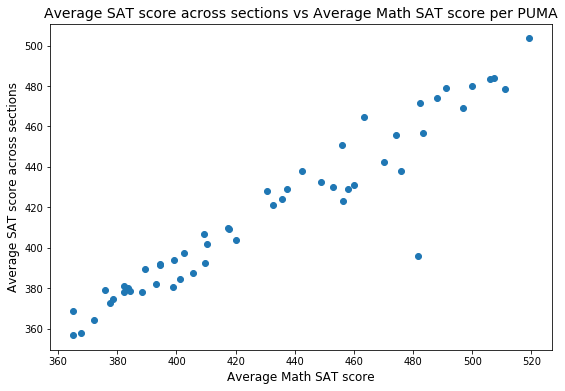

In [339]:
fig = plt.figure(figsize=(9, 6))
plt.scatter(alldata.SATmath, alldata.SATall, marker='o')
ax = plt.gca()
plt.title('Average SAT score across sections vs Average Math SAT score per PUMA', fontsize=14)
plt.xlabel('Average Math SAT score', fontsize=12)
plt.ylabel('Average SAT score across sections', fontsize=12)

In [354]:
print(
    """Pearson's R returns correlation of %.2f and p-value for non-correlation is %.4f
    """ % pearsonr(alldata.SATmath.dropna(), alldata.SATall.dropna())
)

Pearson's R returns correlation of 0.95 and p-value for non-correlation is 0.0000
    


As expected, strong correlation between SATmath and SATall. There may be correlation between math score vs. other SAT scores, and SATall is partially made up with SATmath anyways. Conclusively, VERY strong positive monotonic relationship

#### 6.2 plot the SAT feature by PUMA against 3 of the crime features (3 points)

Text(0.5, 0.98, 'Scatter-Matrix: SAT scores vs. Crime Features')

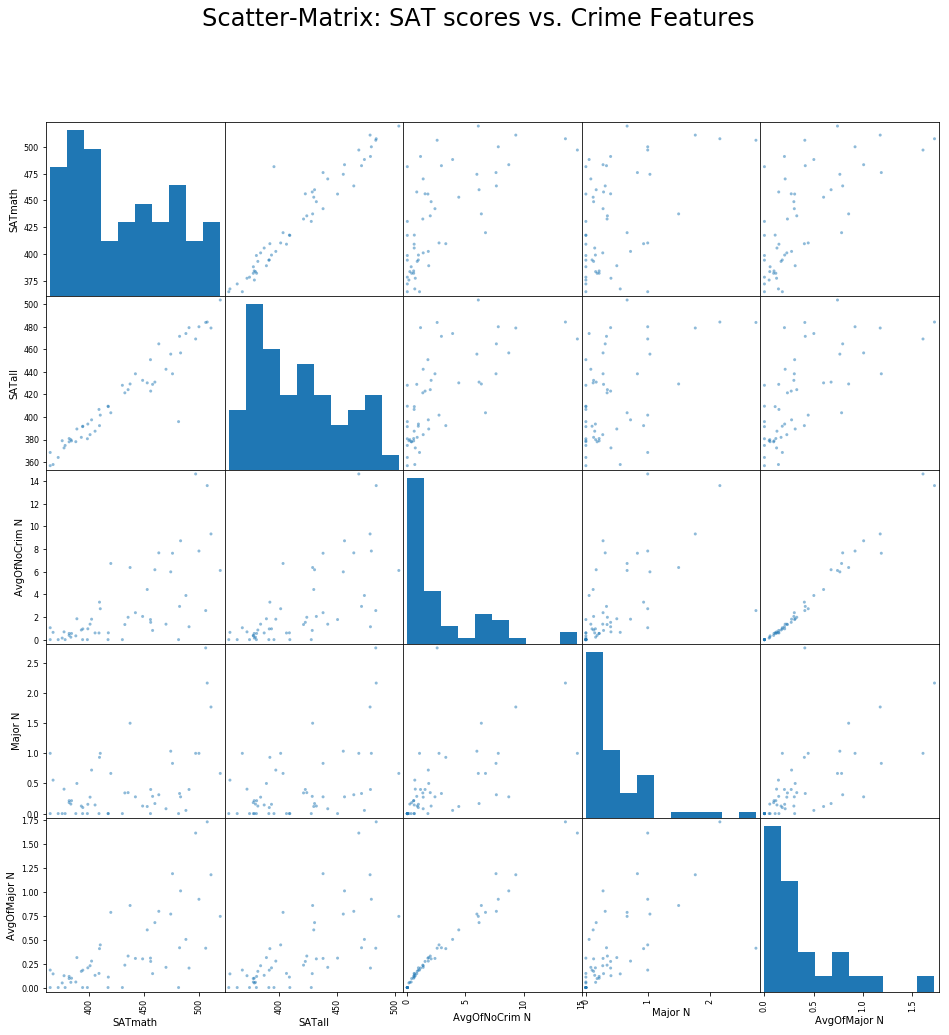

In [366]:
pd.plotting.scatter_matrix(
    alldata[[
        'SATmath'
        , 'SATall'
        , 'AvgOfNoCrim N'
        , 'Major N'
        , 'AvgOfMajor N'
    ]]
    , figsize=(16, 16)
)
plt.suptitle('Scatter-Matrix: SAT scores vs. Crime Features', fontsize=24)

#### Please Refer to the Lower Left Corner's 2-by-3 plots where they have SATmath and SATall as exogenous variables
Surprisingly there seems to be a monotonically positive correlation between SAT scores and crime features in general...

#### 6.3 plot the SAT feature against medical data (3 points)
Use 3 crime features and 2 medial features: asthmaRatio, drugsRatio and Major N, AvgOfNoCrim N, AvgOfMajor N. If you got income in the extra credit above also plot against income

Text(0.5, 0.98, 'Scatter-Matrix: Medical Features vs. Crime Features')

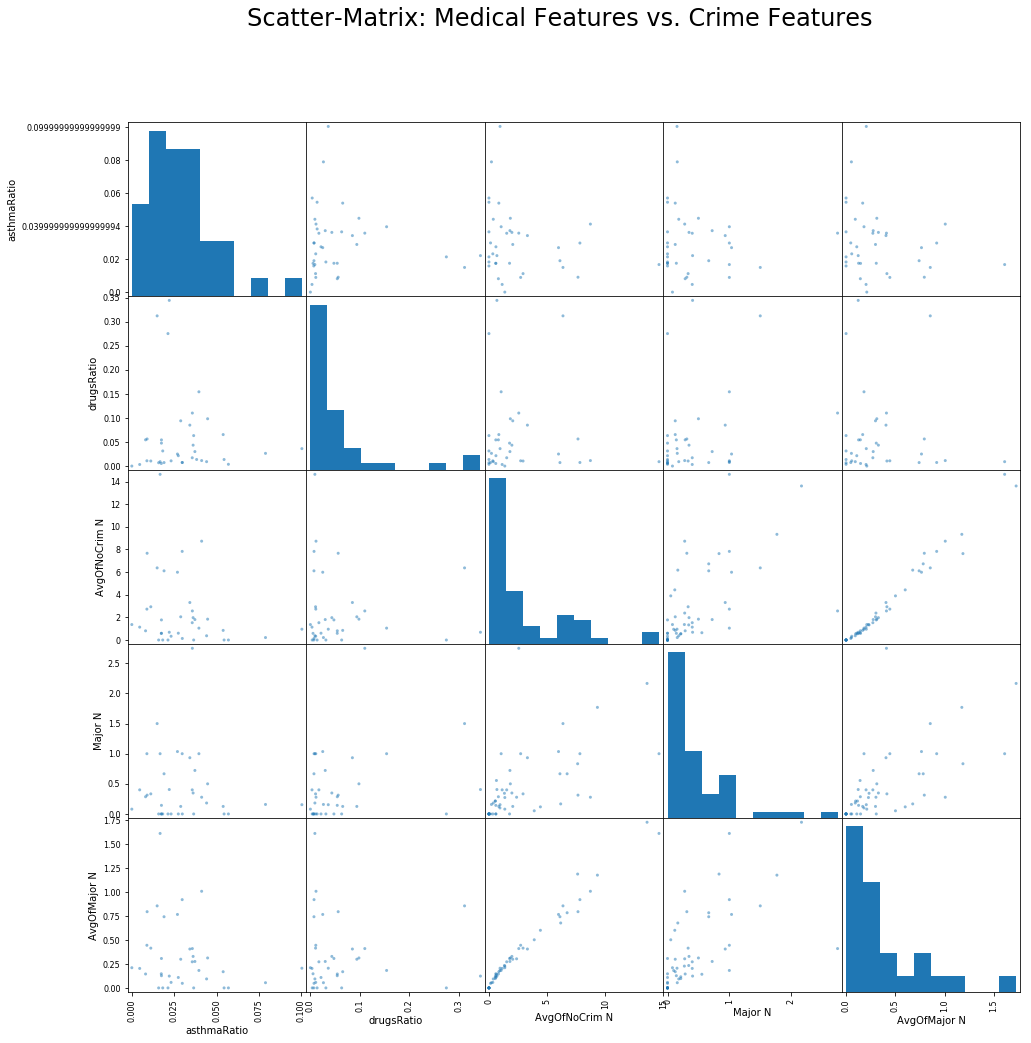

In [367]:
pd.plotting.scatter_matrix(
    alldata[[
        'asthmaRatio'
        , 'drugsRatio'
        , 'AvgOfNoCrim N'
        , 'Major N'
        , 'AvgOfMajor N'
    ]]
    , figsize=(16, 16)
)
plt.suptitle('Scatter-Matrix: Medical Features vs. Crime Features', fontsize=24)

#### Please Refer to the Lower Left Corner's 2-by-3 plots where they have asthmaRatio and drugsRatio as exogenous variables
The majority of the points are clustered near lower left corner of individual plots. This may explain that the values are usually so small and near zero.

In [387]:
schoolfeatures = [c for c in school_res.columns if c != 'puma']
corr_calc_res = np.zeros(len(schoolfeatures) ** 2).reshape(len(schoolfeatures), len(schoolfeatures))

for i, cs in enumerate(product(schoolfeatures, schoolfeatures)):
    c1, c2 = cs
    _corr, _ = pearsonr(alldata[c1].dropna(), alldata[c2].dropna())
    corr_calc_res[i // len(schoolfeatures)][i % len(schoolfeatures)] = _corr

['Major N',
 'Oth N',
 'NoCrim N',
 'Prop N',
 'Vio N',
 'AvgOfMajor N',
 'AvgOfOth N',
 'AvgOfNoCrim N',
 'AvgOfProp N',
 'AvgOfVio N',
 'SATall',
 'SATmath']

[Text(0, 0, 'Major N'),
 Text(0, 0, 'Oth N'),
 Text(0, 0, 'NoCrim N'),
 Text(0, 0, 'Prop N'),
 Text(0, 0, 'Vio N'),
 Text(0, 0, 'AvgOfMajor N'),
 Text(0, 0, 'AvgOfOth N'),
 Text(0, 0, 'AvgOfNoCrim N'),
 Text(0, 0, 'AvgOfProp N'),
 Text(0, 0, 'AvgOfVio N'),
 Text(0, 0, 'SATall'),
 Text(0, 0, 'SATmath')]

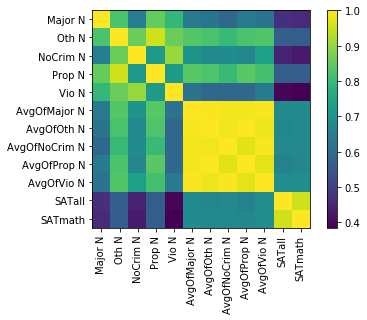

In [395]:
ax = plt.figure().add_subplot(111)
cax = ax.imshow(corr_calc_res)
plt.colorbar(cax)
ax.set_xticks(range(len(schoolfeatures)))
ax.set_xticklabels(schoolfeatures, rotation=90)
ax.set_yticks(range(len(schoolfeatures)))
ax.set_yticklabels(schoolfeatures)

Strong relationship between each criterion of features. i.e. SAT features have strong positive relationship between each other, while Avg Crime features also show some correlation with each other as well. But Avg Crime and Raw Crime columns show somewhat weaker correlation, though positive.

## 7 Mapping (10 points)
plot choropleths (maps where each area is colorcoded by the value of a variable) of

* the SAT features,
* the 3 chosen school crime features
* the two medical discharge fieatures
* the income if you have it from the extra credit


remember your visualization lecture! plot it in a way that allows comparison (hint)

In [401]:
__PUMA_SHP__.columns

Index(['puma', 'shape_area', 'shape_leng', 'geometry'], dtype='object')

In [403]:
choropleth_df = __PUMA_SHP__.merge(
    alldata
    , left_on = 'puma'
    , right_on = 'puma'
)

In [420]:
choropleth_df[[c for c in choropleth_df.columns if c != 'geometry']].head()

,puma,shape_area,shape_leng,asthmaRatio,drugsRatio,Major N,Oth N,NoCrim N,Prop N,Vio N,AvgOfMajor N,AvgOfOth N,AvgOfNoCrim N,AvgOfProp N,AvgOfVio N,SATall,SATmath
0,3701,9.792852e+07,53227.144461,NaN,NaN,0.052632,1.421053,2.947368,0.789474,0.263158,0.501579,2.295263,3.897895,1.413684,0.945263,473.824561,488.157895
1,3702,1.889860e+08,106050.002302,0.036503,0.063314,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,374.740741,378.555556
2,3703,2.670137e+08,304071.257466,NaN,NaN,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,391.400000,394.400000
3,3704,1.062129e+08,47970.901277,0.027440,0.021513,0.000000,2.625000,1.625000,1.375000,1.000000,0.108750,0.416250,0.601250,0.282500,0.188750,409.125000,417.750000
4,4015,8.105438e+07,50007.415493,NaN,NaN,2.166667,7.833333,7.333333,6.833333,2.166667,1.726667,8.568333,13.605000,5.700000,2.811667,484.000000,507.500000


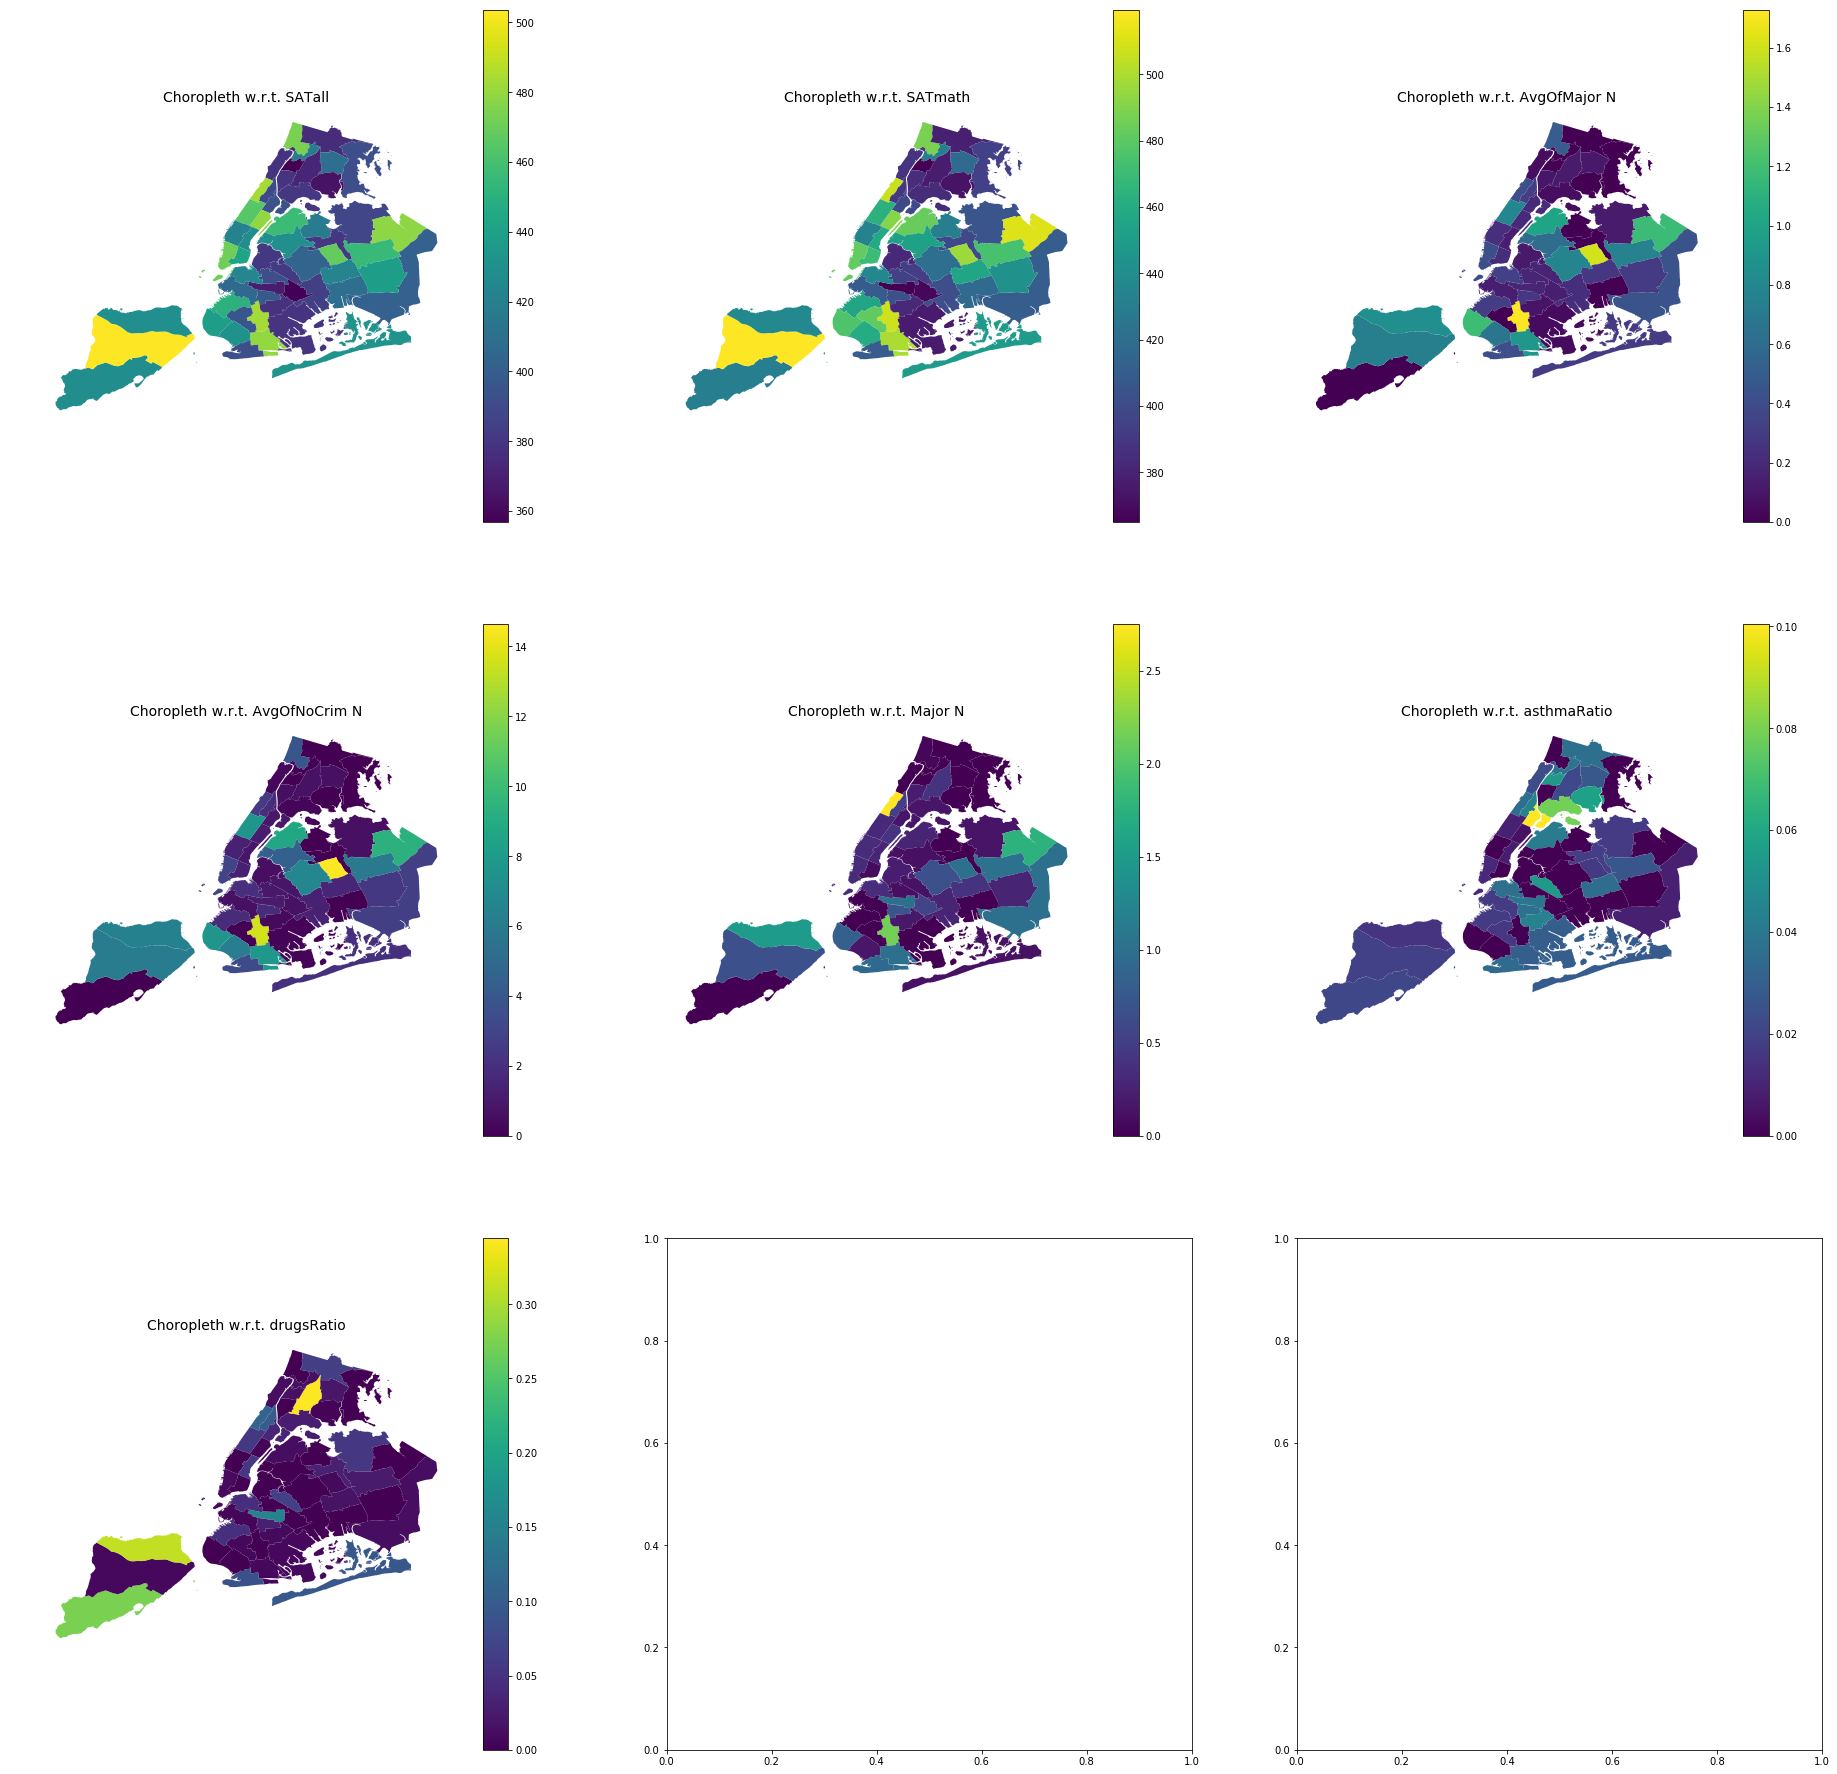

In [436]:
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(32, 32))


choropleth_cols = [
    'SATall'
    , 'SATmath'
    , 'AvgOfMajor N'
    , 'AvgOfNoCrim N'
    , 'Major N'
    , 'asthmaRatio'
    , 'drugsRatio'
]

for i, c in enumerate(choropleth_cols):
    _ax = axes.flat[i]
    if c.startswith('SAT'): # fill with mean if SAT
        ax = choropleth_df[[c, 'geometry']].fillna(choropleth_df[c].mean()).plot(
            column=c
            , cmap='viridis'
            , ax=_ax
            , legend=True
        )
    else: # otherwise, fill with 0
        ax = choropleth_df[['geometry', c]].fillna(0.0).plot(
            column=c
            , cmap='viridis'
            , ax=_ax
            , legend=True            
        )        
    ax.set_title('Choropleth w.r.t. %s' % c, fontsize=14)
    ax.axis('off') 


## 8 start with linear modeling (10 points)
create the models and discuss the results including pros and cons of the model choice (hint)

### 8.1 create a multivariate-linear model using only the crime in school features, but using all 10 of them, predicting the chosen SAT feature (5 points)
for example with

statsmodels.formula()
hint

print and discuss the model summary

In [439]:
# remove all spaces in column names
mv_dta = alldata.copy(deep=True)
mv_dta.rename(
    dict(zip(
        [c for c in alldata]
        , [c.replace(' ', '_') for c in alldata]
    ))
    , axis=1
    , inplace=True
)
mv_dta.head()

,puma,asthmaRatio,drugsRatio,Major_N,Oth_N,NoCrim_N,Prop_N,Vio_N,AvgOfMajor_N,AvgOfOth_N,AvgOfNoCrim_N,AvgOfProp_N,AvgOfVio_N,SATall,SATmath
0,3701,NaN,NaN,0.052632,1.421053,2.947368,0.789474,0.263158,0.501579,2.295263,3.897895,1.413684,0.945263,473.824561,488.157895
1,3702,0.036503,0.063314,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,374.740741,378.555556
2,3703,NaN,NaN,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,391.400000,394.400000
3,3704,0.027440,0.021513,0.000000,2.625000,1.625000,1.375000,1.000000,0.108750,0.416250,0.601250,0.282500,0.188750,409.125000,417.750000
4,3705,0.022103,0.344390,0.405405,2.162162,3.540541,0.945946,1.054054,0.123243,0.461081,0.685135,0.311351,0.212162,372.558559,377.567568


In [440]:
mv_model = smf.ols(
    formula='SATall~Major_N+Oth_N+NoCrim_N+Prop_N+Vio_N+AvgOfMajor_N+AvgOfOth_N+AvgOfNoCrim_N+AvgOfProp_N+AvgOfVio_N'
    , data=mv_dta
).fit()
mv_model.summary()

/Users/sunghoonyang/PycharmProjects/ds_workspace/pui2018fall/lib/python3.6/site-packages/statsmodels/base/data.py:480: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  if hasattr(x, 'ix'):


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 SATall   R-squared:                       0.581
Model:                            OLS   Adj. R-squared:                  0.481
Method:                 Least Squares   F-statistic:                     5.825
Date:                Sat, 15 Dec 2018   Prob (F-statistic):           1.92e-05
Time:                        19:39:59   Log-Likelihood:                -246.07
No. Observations:                  53   AIC:                             514.1
Df Residuals:                      42   BIC:                             535.8
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept       385.5309      7.062     54.593      0.000     371.279     399.782
Major_N          51.2228     26.514      1.932      0.060      -2.285     104.731
Oth_N            33.8353     19.216      1.761      0.086      -4.944      72.615
NoCrim_N         -3.2924      3.882     -0.848      0.401     -11.127       4.542
Prop_N          -41.7984     23.186     -1.803      0.079     -88.589       4.993
Vio_N           -41.1509     23.761     -1.732      0.091     -89.104       6.802
AvgOfMajor_N    110.8351    246.079      0.450      0.655    -385.772     607.443
AvgOfOth_N       36.8854     95.264      0.387      0.701    -155.365     229.136
AvgOfNoCrim_N   -23.9974     19.030     -1.261      0.214     -62.401      14.407
AvgOfProp_N     -65.8081    127.503     -0.516      0.608    -323.120     191.504
AvgOfVio_N      108.5151    127.130      0.854      0.398    -148.044     365.074
==============================================================================
Omnibus:                        6.174   Durbin-Watson:                   1.185
Prob(Omnibus):                  0.046   Jarque-Bera (JB):                5.241
Skew:                           0.739   Prob(JB):                       0.0728
Kurtosis:                       3.436   Cond. No.                         606.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

The summary shows an OK $R^2$ = 0.581, but there seems to be evidence for multicollinearity. We know that p-value column shows the p-value for Hypothesis testing where $H_0: coef = 0$. Features such as **NoCrim_N, AvgOfMajor_N or AvgOfProp_N** all show high p-values which means their robustness may not be trusted.

### 8.2 add drugs and asthma discharge data and create a new multilinear model (5 points)
Extra credit: if you have income add income data and create a new multilinear model¶

In [443]:
mv_model_med = smf.ols(
    formula='SATall~Major_N+Oth_N+NoCrim_N+Prop_N+Vio_N+AvgOfMajor_N+AvgOfOth_N+AvgOfNoCrim_N+AvgOfProp_N+AvgOfVio_N+drugsRatio+asthmaRatio'
    , data=mv_dta
).fit()
mv_model_med.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 SATall   R-squared:                       0.676
Model:                            OLS   Adj. R-squared:                  0.514
Method:                 Least Squares   F-statistic:                     4.167
Date:                Sat, 15 Dec 2018   Prob (F-statistic):            0.00143
Time:                        19:46:12   Log-Likelihood:                -167.84
No. Observations:                  37   AIC:                             361.7
Df Residuals:                      24   BIC:                             382.6
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept       412.9251     12.687     32.548      0.000     386.741     439.109
Major_N          78.5393     35.557      2.209      0.037       5.152     151.926
Oth_N            60.2715     28.147      2.141      0.043       2.179     118.364
NoCrim_N         -4.2285      5.060     -0.836      0.412     -14.672       6.215
Prop_N          -69.9042     31.529     -2.217      0.036    -134.978      -4.831
Vio_N           -64.4171     33.230     -1.939      0.064    -133.000       4.166
AvgOfMajor_N     16.2461    438.707      0.037      0.971    -889.200     921.692
AvgOfOth_N      -78.3858    178.676     -0.439      0.665    -447.156     290.384
AvgOfNoCrim_N    -6.7392     25.035     -0.269      0.790     -58.410      44.931
AvgOfProp_N      98.3514    260.872      0.377      0.709    -440.062     636.765
AvgOfVio_N      103.7954    246.688      0.421      0.678    -405.343     612.934
drugsRatio      -83.6514     69.933     -1.196      0.243    -227.987      60.684
asthmaRatio    -726.7801    242.498     -2.997      0.006   -1227.271    -226.290
==============================================================================
Omnibus:                        3.837   Durbin-Watson:                   1.319
Prob(Omnibus):                  0.147   Jarque-Bera (JB):                2.551
Skew:                           0.583   Prob(JB):                        0.279
Kurtosis:                       3.546   Cond. No.                         872.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

The summary shows an OK $R^2$ = 0.676, but there seems to be evidence for multicollinearity and possibly overfitting, as the sample size is reduced to 37, due to NaNs in medical features. Features such as **NoCrim_N, AvgOfMajor_N, AvgOfOth_N, AvgOfNoCrim_N, AvgOfProp_N, AvgOfVio_N** all show very high p-values which means their robustness may not be trusted.

## 9 compare the linear models (10 points):
which is the right level of complexity? this should be a proper statistical test that returns a p-value for the null hypothesis that one model is better than the other. (hint)

In [453]:
alpha = 0.05
print ("LR : ", -2 * (mv_model.llf - (mv_model_med.llf)))
print ("LR comparison test:", mv_model_med.compare_lr_test(mv_model))
LR = mv_model_med.compare_lr_test(mv_model)

if LR[0] < 3.84: #0.05 level for 1 DOF chi sq distribution 
    print ("It is NOT POSSIBLE") 
    
print ("reject the Null hypothesis that the restricted Crime Feature Only Multivariate Regression " + 
       "model is better than the Multivariate Regression fit with Medical Feature Added, as per p-value: ", str(LR[1]), "< %.3f"%alpha)


LR :  156.466255919444
LR comparison test: (156.466255919444, 4.088419091370245e-24, 18.0)
reject the Null hypothesis that the restricted Crime Feature Only Multivariate Regression model is better than the Multivariate Regression fit with Medical Feature Added, as per p-value:  4.088419091370245e-24 < 0.050


## 10 random forest regression on school-related data only (10 points)
create, the models, evaluate their performance, assess the feature importance. (hint)

NOTE: do not forget to properly prepare your data for modeling!!

### 10.1 create a random forest model using only the crime in school data, but using all 10 crime in school features (5 points)
measure the model accuracy, precision, recall and the feature importance #(hints)

In [480]:
rfc_sch_only = alldata[['Major N', 'Oth N', 'NoCrim N', 'Prop N', 'Vio N', 'AvgOfMajor N', 'AvgOfOth N', 'AvgOfNoCrim N', 'AvgOfProp N', 'AvgOfVio N', 'SATall']].fillna(0.0).copy()

for c in rfc_sch_only.columns:
    scaler = StandardScaler().fit(np.array(rfc_sch_only[c]).reshape(-1, 1))
    rfc_sch_only[c] = scaler.transform(np.array(rfc_sch_only[c]).reshape(-1, 1))

rfc_sch_only.astype(float)
print('Standardized Means')
pprint(rfc_sch_only.mean(axis=0))
print('Standardized STD')
pprint(rfc_sch_only.std(axis=0))

Standardized Means
Major N          4.239033e-17
Oth N            4.239033e-17
NoCrim N         6.661338e-17
Prop N           1.312082e-16
Vio N           -4.844610e-17
AvgOfMajor N     1.503848e-16
AvgOfOth N       3.532528e-17
AvgOfNoCrim N   -3.431598e-17
AvgOfProp N      7.216450e-17
AvgOfVio N      -8.074349e-17
SATall          -3.401320e-16
dtype: float64
Standardized STD
Major N          1.009217
Oth N            1.009217
NoCrim N         1.009217
Prop N           1.009217
Vio N            1.009217
AvgOfMajor N     1.009217
AvgOfOth N       1.009217
AvgOfNoCrim N    1.009217
AvgOfProp N      1.009217
AvgOfVio N       1.009217
SATall           1.009217
dtype: float64


In [481]:
rfc_sch_only.head()

,Major N,Oth N,NoCrim N,Prop N,Vio N,AvgOfMajor N,AvgOfOth N,AvgOfNoCrim N,AvgOfProp N,AvgOfVio N,SATall
0,-0.664011,-0.246875,-0.007870,-0.308824,-0.551692,0.342559,0.358174,0.347520,0.309293,0.407783,0.828459
1,-0.756901,-0.883577,-0.855311,-0.803936,-0.838042,-0.900846,-0.799536,-0.793353,-0.805601,-0.886083,-0.312176
2,-0.756901,-0.883577,-0.855311,-0.803936,-0.838042,-0.900846,-0.799536,-0.793353,-0.805601,-0.886083,-0.120397
3,-0.756901,0.292553,-0.388083,0.058384,0.250089,-0.631257,-0.589583,-0.617373,-0.582809,-0.627724,0.083649
4,-0.041394,0.085179,0.162682,-0.210693,0.308907,-0.595328,-0.566971,-0.592821,-0.560056,-0.595678,-0.337297


In [482]:
X_train, X_test, y_train, y_test = train_test_split(
    rfc_sch_only.iloc[:, :-1]
    , rfc_sch_only.iloc[:, 1]
    , test_size=0.33
    , random_state=42
    , shuffle=True
)
X_train.head()

,Major N,Oth N,NoCrim N,Prop N,Vio N,AvgOfMajor N,AvgOfOth N,AvgOfNoCrim N,AvgOfProp N,AvgOfVio N
27,-0.756901,-0.691556,-0.773161,-0.624753,-0.682595,-0.536082,-0.619396,-0.621502,-0.564501,-0.670987
46,1.071050,0.780607,1.188169,0.898307,0.794154,0.997345,0.876663,0.958812,0.837314,1.030710
45,1.008018,-0.136828,0.326735,-0.037429,0.491896,0.200923,0.018698,0.005364,0.005826,0.184614
53,-0.756901,-0.883577,-0.855311,-0.803936,-0.838042,-0.900846,-0.799536,-0.793353,-0.805601,-0.886083
15,-0.205364,-0.323515,-0.244321,-0.020008,-0.702026,1.068394,0.788665,1.449381,0.654377,1.140580


In [487]:
np.array(y_train)

array([-0.69155553,  0.78060694, -0.13682764, -0.88357672, -0.32351491,
       -0.81283207, -0.15389619, -0.60354581, -0.06894136,  2.62614395,
       -0.07708771,  1.80471996, -0.24687487,  2.10341959, -0.88357672,
       -0.23639418,  0.25148188, -0.88357672,  1.09530834, -0.88357672,
        0.75927125,  0.2365469 ,  1.58069524, -0.37152021,  2.18383873,
       -0.74356127,  3.5595803 , -0.48929321, -0.82757054, -0.88357672,
       -0.53153787, -0.88357672, -0.21150255, -0.07708771,  0.01252217,
        1.61269877])

In [491]:
regr = RandomForestRegressor(
    max_depth=2
    , random_state=0
    , n_estimators=100
)
model = regr.fit(np.array(X_train), np.array(y_train))
model

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=2,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=None,
           oob_score=False, random_state=0, verbose=0, warm_start=False)

In [503]:
print(
"""coefficient of determination R^2 of the prediction is %.3f""" % model.score(X_test, y_test)
)

coefficient of determination R^2 of the prediction is 0.885


### 10.2 measure the feature importance of the features in this model to select the 3 most predictive features (5 points)
You can use the code featureImportancePlotter.py if you want to visualize feature importance

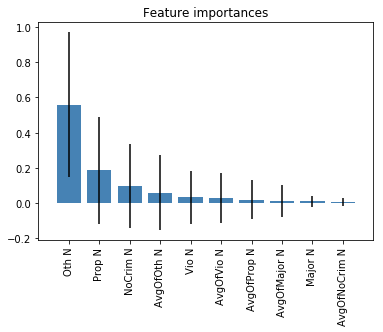

In [506]:
featureImportancePlot(model, rfc_sch_only.columns[:-1])

Oth N is by far the most important feature. The Feature importance decreases geometrically as we move to subsequent features of increasingly less importance. However, Standard error of feature importance is also a considerable part of the predicted values.

## 11 random forest with crime and medical (and income if you have it) features
hints on modeling

### 11.1 create a random forest model that only uses the 3 most predictive features about school crimes and the health features (and income if you have it from the EC) (3 points)

In [507]:
alldata.columns

Index(['puma', 'asthmaRatio', 'drugsRatio', 'Major N', 'Oth N', 'NoCrim N',
       'Prop N', 'Vio N', 'AvgOfMajor N', 'AvgOfOth N', 'AvgOfNoCrim N',
       'AvgOfProp N', 'AvgOfVio N', 'SATall', 'SATmath'],
      dtype='object')

In [508]:
rfc_cm = alldata[['Oth N', 'NoCrim N', 'Prop N', 'asthmaRatio', 'drugsRatio', 'SATall']].fillna(0.0).copy()

for c in rfc_sch_only.columns:
    scaler = StandardScaler().fit(np.array(rfc_sch_only[c]).reshape(-1, 1))
    rfc_sch_only[c] = scaler.transform(np.array(rfc_sch_only[c]).reshape(-1, 1))

rfc_sch_only.astype(float)
print('Standardized Means')
pprint(rfc_sch_only.mean(axis=0))
print('Standardized STD')
pprint(rfc_sch_only.std(axis=0))

Standardized Means
Major N         -3.835316e-17
Oth N           -2.624164e-17
NoCrim N        -4.642751e-17
Prop N          -3.835316e-17
Vio N           -1.614870e-17
AvgOfMajor N     7.065056e-17
AvgOfOth N      -2.422305e-17
AvgOfNoCrim N   -3.734387e-17
AvgOfProp N      7.216450e-17
AvgOfVio N      -3.280204e-17
SATall           1.312082e-17
dtype: float64
Standardized STD
Major N          1.009217
Oth N            1.009217
NoCrim N         1.009217
Prop N           1.009217
Vio N            1.009217
AvgOfMajor N     1.009217
AvgOfOth N       1.009217
AvgOfNoCrim N    1.009217
AvgOfProp N      1.009217
AvgOfVio N       1.009217
SATall           1.009217
dtype: float64


In [509]:
rfc_cm.head()

,Oth N,NoCrim N,Prop N,asthmaRatio,drugsRatio,SATall
0,1.421053,2.947368,0.789474,0.000000,0.000000,473.824561
1,0.000000,0.000000,0.000000,0.036503,0.063314,374.740741
2,0.000000,0.000000,0.000000,0.000000,0.000000,391.400000
3,2.625000,1.625000,1.375000,0.027440,0.021513,409.125000
4,2.162162,3.540541,0.945946,0.022103,0.344390,372.558559


In [510]:
X_train, X_test, y_train, y_test = train_test_split(
    rfc_cm.iloc[:, :-1]
    , rfc_cm.iloc[:, 1]
    , test_size=0.33
    , random_state=42
    , shuffle=True
)
X_train.head()

,Oth N,NoCrim N,Prop N,asthmaRatio,drugsRatio
27,0.428571,0.285714,0.285714,0.017395,0.005346
46,3.714286,7.107143,2.714286,0.026930,0.025002
45,1.666667,4.111111,1.222222,0.008893,0.010929
53,0.000000,0.000000,0.000000,0.000000,0.000000
15,1.250000,2.125000,1.250000,0.009021,0.056296


In [511]:
np.array(y_train)

array([ 0.28571429,  7.10714286,  4.11111111,  0.        ,  2.125     ,
        0.10526316,  2.34285714,  1.3125    ,  3.18181818,  7.33333333,
        3.        ,  5.875     ,  2.94736842,  6.66666667,  0.        ,
        3.61111111,  4.26666667,  0.        ,  8.25      ,  0.        ,
       13.33333333,  7.16666667,  6.83333333,  1.        ,  5.46153846,
        0.3125    , 17.16666667,  0.92      ,  0.25      ,  0.        ,
        1.14285714,  0.        ,  3.5       ,  3.6       ,  1.6       ,
        9.85714286])

In [512]:
regr = RandomForestRegressor(
    max_depth=2
    , random_state=0
    , n_estimators=100
)
model = regr.fit(np.array(X_train), np.array(y_train))
model

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=2,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=None,
           oob_score=False, random_state=0, verbose=0, warm_start=False)

### 11.2 evaluate the performance of the model (3 points)

In [513]:
print(
"""coefficient of determination R^2 of the prediction is %.3f""" % model.score(X_test, y_test)
)

coefficient of determination R^2 of the prediction is 0.897


Although the features were reduced to top 3 most important crime related features, and two medical features, the $R^2$ has improved by 1 percent.

### 11.3 discuss the importance of each feature in the model (4 points)

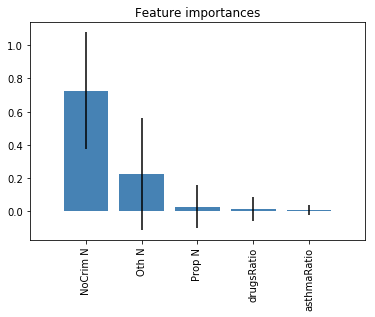

In [516]:
featureImportancePlot(model, rfc_cm.columns[:-1])

The most important feature for this model now NoCrim N. is The standard error, at least for the most important feature of the model in this case, covers a smaller portion of the predicted value. Other features however, cannot guarantee the importance, because standard deviation includes zero value.

In [ ]:
## End of Notebook